In [41]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import mean_squared_error
from warnings import filterwarnings
filterwarnings('ignore')

In [42]:
df = pd.read_csv(r'/content/diabetes.csv', sep = ',')

In [43]:
df.shape

(768, 9)

In [44]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [45]:
df.columns = [col.lower() for col in df.columns]
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [46]:
for i in df.columns:
    print(df[i].head(1))
    print(df[i].min())
    print(df[i].max())
    print(df[i].mean())
    print("##############################")

0    6
Name: pregnancies, dtype: int64
0
17
3.8450520833333335
##############################
0    148
Name: glucose, dtype: int64
0
199
120.89453125
##############################
0    72
Name: bloodpressure, dtype: int64
0
122
69.10546875
##############################
0    35
Name: skinthickness, dtype: int64
0
99
20.536458333333332
##############################
0    0
Name: insulin, dtype: int64
0
846
79.79947916666667
##############################
0    33.6
Name: bmi, dtype: float64
0.0
67.1
31.992578124999998
##############################
0    0.627
Name: diabetespedigreefunction, dtype: float64
0.078
2.42
0.47187630208333325
##############################
0    50
Name: age, dtype: int64
21
81
33.240885416666664
##############################
0    1
Name: outcome, dtype: int64
0
1
0.3489583333333333
##############################


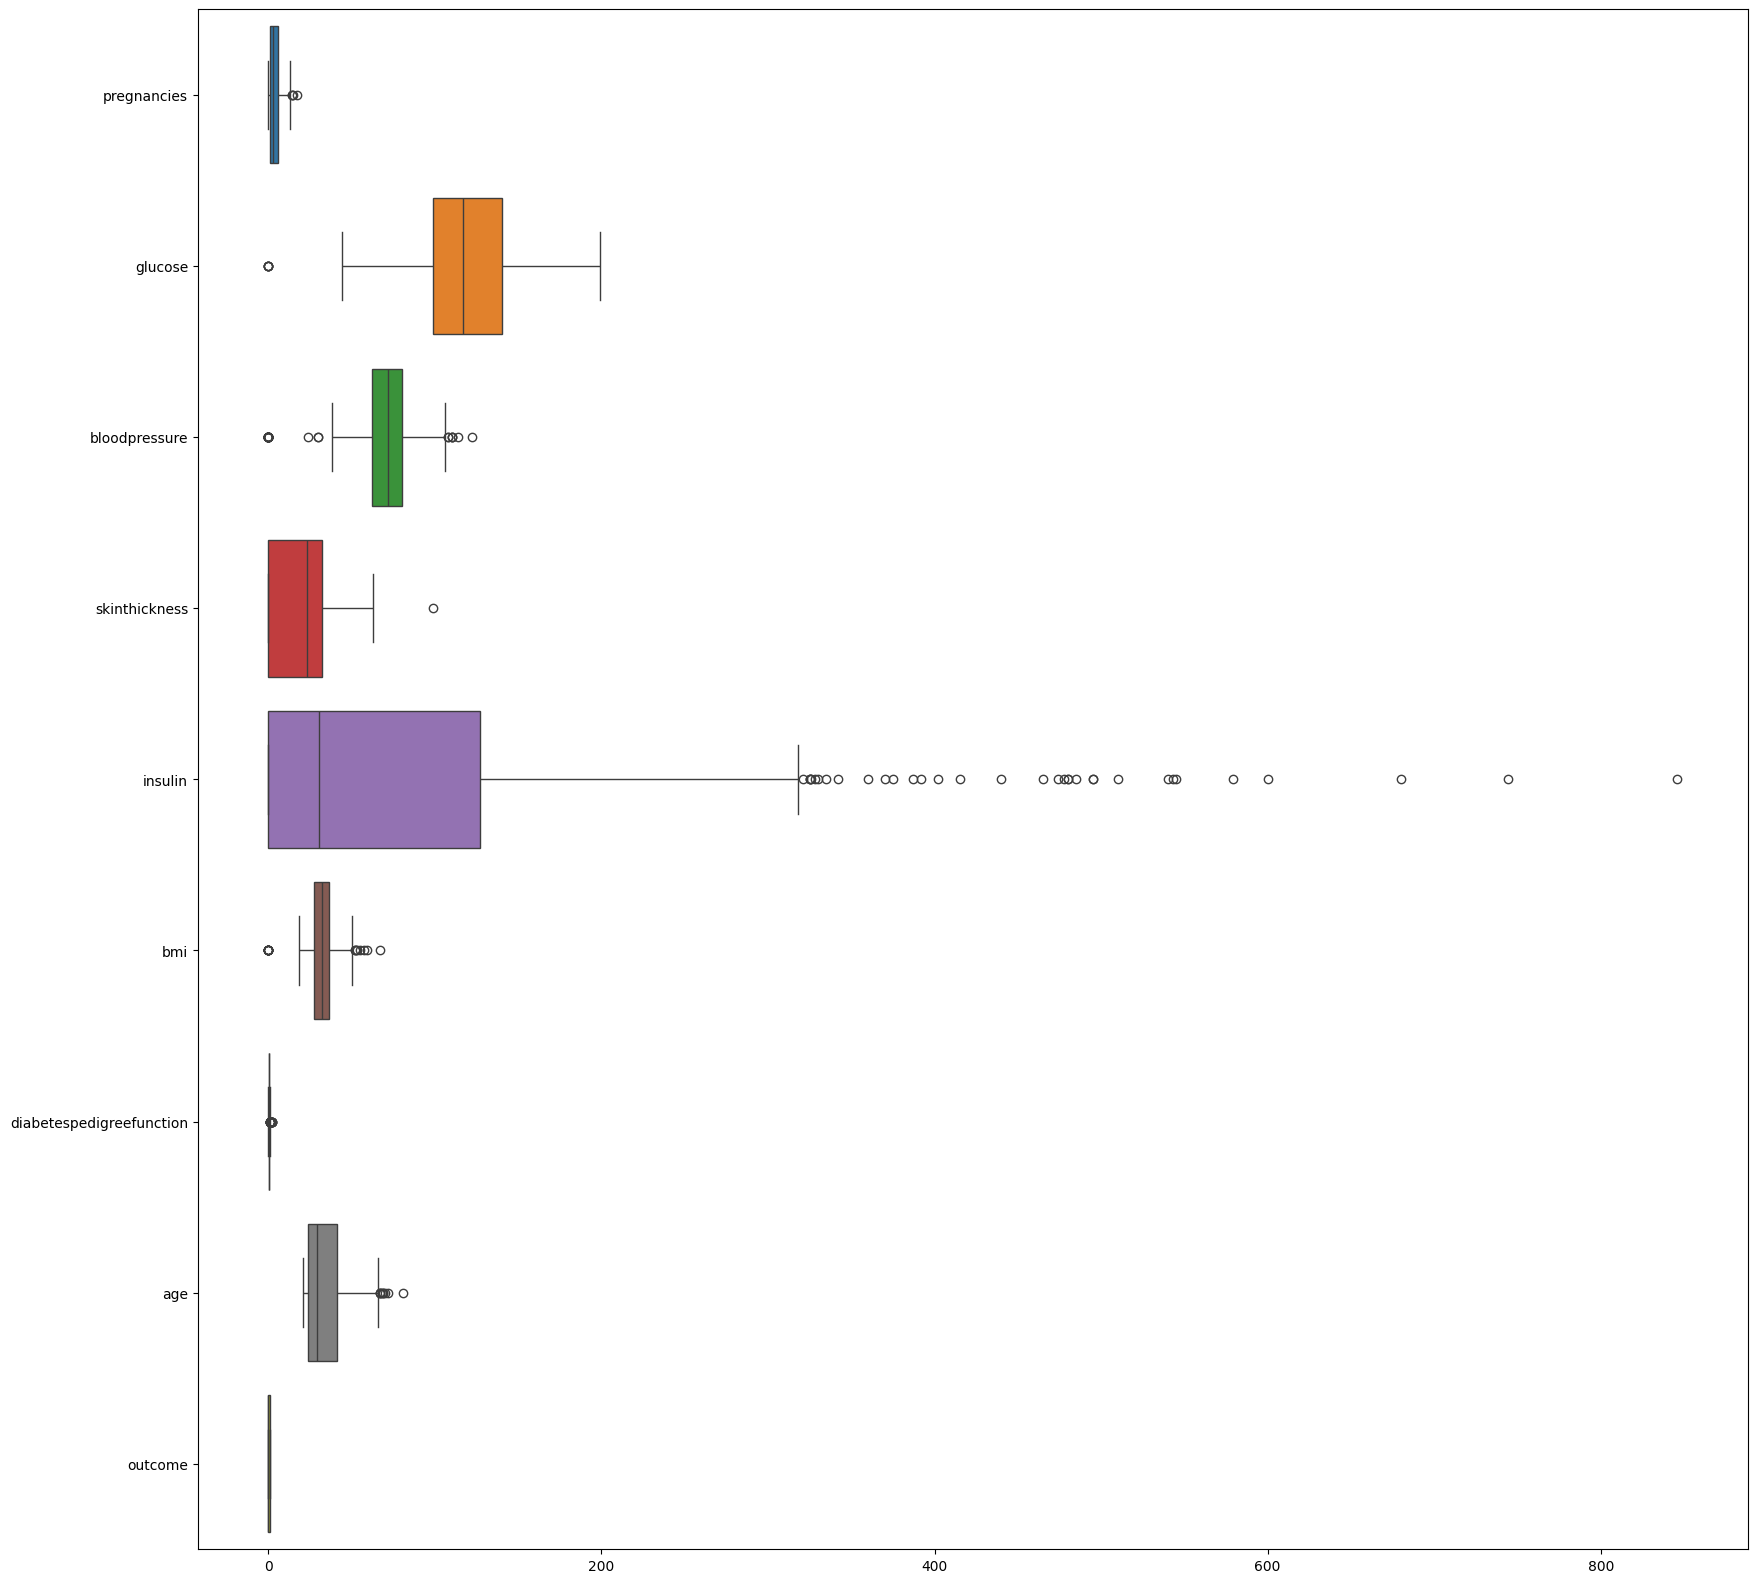

In [47]:
f, ax = plt.subplots(figsize=(20,20))
fig = sns.boxplot(data=df, orient="h")

<Axes: ylabel='outcome'>

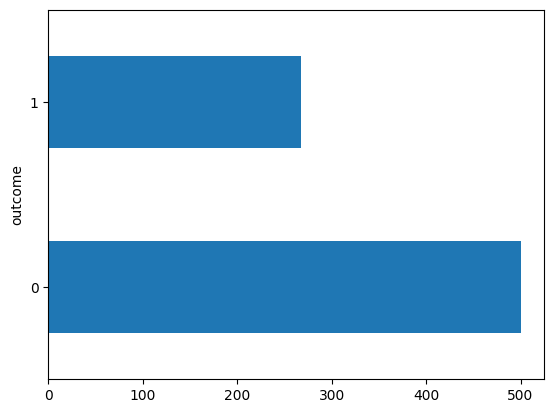

In [48]:
df["outcome"].value_counts().plot.barh()

<Axes: >

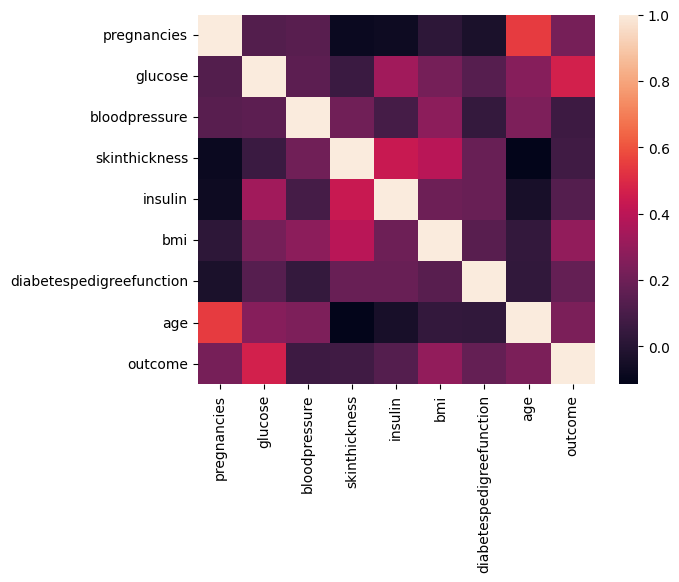

In [49]:
corr = df.corr()

sns.heatmap(corr,
         xticklabels=corr.columns,
         yticklabels=corr.columns)

In [50]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [51]:
def outlier_thresholds(dataframe, col_name, q1=0.15, q3=0.85):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + interquantile_range
    low_limit = quartile1 - 1.3 * interquantile_range
    return low_limit, up_limit


In [52]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [53]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

    for col in df.columns:
        print(col, grab_outliers(df,col))

In [54]:
def replace_with_thresholds(dataframe, variable):
        low_limit, up_limit = outlier_thresholds(dataframe, variable)
        dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
        dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
        print(replace_with_thresholds(df, col))

None
None
None
None
None
None
None
None


In [55]:
variables = ["skinthickness", "insulin"]
df[variables] = df[variables].replace(0,np.NaN)
df.isnull().sum()

,0
pregnancies,0
glucose,0
bloodpressure,0
skinthickness,227
insulin,374
bmi,0
diabetespedigreefunction,0
age,0
outcome,0


In [56]:
df["skinthickness"].fillna(df.groupby("outcome")["skinthickness"].transform("mean"), inplace=True)
df["insulin"].fillna(df.groupby('outcome')["insulin"].transform("mean"), inplace=True)
df.isnull().sum()

,0
pregnancies,0
glucose,0
bloodpressure,0
skinthickness,0
insulin,0
bmi,0
diabetespedigreefunction,0
age,0
outcome,0


In [57]:
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6.0,148.0,72.0,35.000000,189.692308,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.000000,125.155303,26.6,0.351,31.0,0
2,8.0,183.0,64.0,32.861111,189.692308,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.000000,94.000000,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.000000,168.000000,43.1,1.321,33.0,1


In [58]:
y = df["outcome"]
X = df.drop(["outcome"], axis=1)
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=42)

knn_model = KNeighborsClassifier().fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8246753246753247

In [59]:
knn_params = {"n_neighbors": np.arange(1,50)}

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, knn_params, cv=10)
knn_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [60]:
print("Best params " + str(knn_cv.best_params_))

Best params {'n_neighbors': 6}


In [61]:
knn = KNeighborsClassifier(n_neighbors=7)
knn_tuned = knn.fit(X_train, y_train)
y_pred = knn_tuned.predict(X_test)
k = accuracy_score(y_test, y_pred)
k

0.8246753246753247

In [62]:
### Random Forest

In [63]:
y = df["outcome"]
X = df.drop(["outcome"], axis=1)
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=42)

rf_model = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
rf=accuracy_score(y_test, y_pred)
rf

0.8701298701298701

In [64]:
### Gradient boosting

In [65]:
y = df["outcome"]
X = df.drop(["outcome"], axis=1)
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=42)

gbm_model = GradientBoostingClassifier().fit(X_train, y_train)
y_pred = gbm_model.predict(X_test)
gb = accuracy_score(y_test, y_pred)
gb

0.8636363636363636

In [66]:
### xgbm

In [67]:
y = df["outcome"]
X = df.drop(["outcome"], axis=1)
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=42)

xgbm_model = XGBClassifier().fit(X_train, y_train)
y_pred = xgbm_model.predict(X_test)
xgb=accuracy_score(y_test, y_pred)
xgb

0.8441558441558441

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV as gscv
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from scipy.stats import expon, uniform

dtc=DecisionTreeClassifier(criterion='entropy', random_state=42)
ada = AdaBoostClassifier(dtc,random_state=42)
predictor = ada.fit(X_train, y_train)
y_pred = predictor.predict(X_test)
accuracy_ada = accuracy_score(y_test, y_pred)

print(accuracy_ada)

0.8311688311688312


In [69]:
LRclassifier = LogisticRegression(max_iter=1000, random_state=1, solver='liblinear', penalty='l1')
LRclassifier.fit(X_train, y_train)

y_pred_LR = LRclassifier.predict(X_test)
LRAcc = accuracy_score(y_pred_LR, y_test)
print(LRAcc)

0.7987012987012987


In [70]:
DTCclassifier = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, criterion='entropy', min_samples_split=5,
                                       splitter='random', random_state=1)

DTCclassifier.fit(X_train, y_train)
y_pred_DTC = DTCclassifier.predict(X_test)
DTCAcc = accuracy_score(y_pred_DTC, y_test)
print(DTCAcc)

0.6948051948051948


In [71]:
SVMclassifier = SVC(kernel='linear', max_iter=1000, C=10, probability=True)
SVMclassifier.fit(X_train, y_train)

y_pred_SVM = SVMclassifier.predict(X_test)
SVMAcc = accuracy_score(y_pred_SVM, y_test)
print(SVMAcc)

0.7337662337662337


In [72]:
GNBclassifier = GaussianNB(var_smoothing=0.1)
GNBclassifier.fit(X_train, y_train)

y_pred_GNB = GNBclassifier.predict(X_test)
GNBAcc = accuracy_score(y_pred_GNB, y_test)
print(GNBAcc)

0.8051948051948052


In [73]:
models = pd.DataFrame({
    'Model' : [ 'KNN', 'Decision Tree', 'Random Forest','Ada Boost',
             'Gradient Boosting', 'XgBoost', 'Logistic Regression', 'Naive Bayes', 'SVM'],
    'Accuracy' : [k, DTCAcc, rf, accuracy_ada, gb, xgb,LRAcc, GNBAcc, SVMAcc]
})


df1 = models.sort_values(by = 'Accuracy', ascending = False)

Text(0.5, 1.0, 'Model Vs Accuracy for Diabetes')

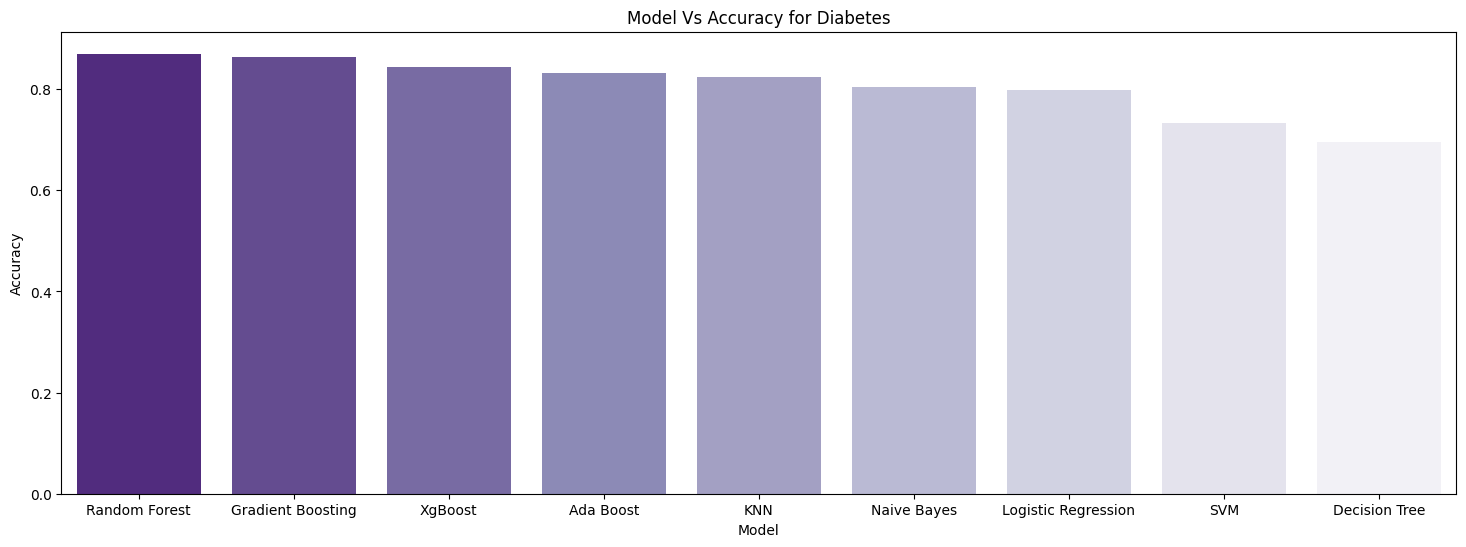

In [74]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,6))
sns.barplot(df1, x = 'Model', y = 'Accuracy', palette = 'Purples_r')
plt.title("Model Vs Accuracy for Diabetes")

In [77]:
# Define the models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

# Set up cross-validation (e.g., 5-fold) for each model
cross_val_results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cross_val_results[model_name] = np.mean(scores)  # Average accuracy for each model

# Identify the best model
best_model_name = max(cross_val_results, key=cross_val_results.get)
best_model_score = cross_val_results[best_model_name]

print("Cross-validation results:", cross_val_results)
print(f"Best model: {best_model_name} with accuracy: {best_model_score:.2f}")

# Train the best model on the full training dataset
best_model = models[best_model_name]
best_model.fit(X, y)

Cross-validation results: {'Logistic Regression': 0.7969187675070029, 'Decision Tree': 0.8542653425006366, 'Random Forest': 0.8763347763347763, 'SVM': 0.8411170528817588, 'K-Nearest Neighbors': 0.8502504031915796, 'Naive Bayes': 0.7878278584160938}
Best model: Random Forest with accuracy: 0.88


RandomForestClassifier()

In [75]:
import joblib

In [78]:
file = open("diabetes_model", "wb")
joblib.dump(best_model,file)
file.close()